# Welcome to your first Markov chain! This simple example runs a chain to generate an ensemble of plans for Colorado Congressional Districts and outputs charts showing various statistics for the ensemble.

### Some Notes:

Please make sure you have the file tree as described, it will make running this chain MUCH easier. 

It is quite likely you will end up with numerous errors as you try to run this. Try your best to see what the error is talking about and ask questions as necessary! 

If errors persist, it might be necessary to restart this notebook. Above, go to Kernel -> Restart & Run All.

The tqdm package which is imported in the first codeblock is just a widget that keeps track of progress for long chain runs.  You'll need to install it into your pythom environment with "conda install tqdm" if you want to use this feature; if not, just remove that line from the import list.

FILE TREE
** Make sure your files/folders match this - names and locations! **

Folder where this notebook is located:

--Data

    --CO_Shapefile_2018_Jan2020

        --co_precincts.cpg

        --co_precincts.dbf

        --co_precincts.prj

        --co_precincts.shx

        --co_precincts.shp
    
--Outputs  (Only if you want to save the results)

    --Benchmarking   (Only if you want to save the results)

--Gerrychain Intro (CO) (this document!)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import json
import networkx as nx
import time
import os
import csv
import networkx as nx
import math
import pickle


from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.constraints.validity import within_percent_of_ideal_population
from gerrychain.metrics import mean_median,efficiency_gap
from gerrychain.proposals import recom
from functools import partial
from gerrychain.tree import recursive_tree_part

from tqdm import tqdm

ModuleNotFoundError: No module named 'pyproj'

The next 2 cells read in the precinct data into a graph (for visuals) and a Geopandas Dataframe (for quantitative data).

Note these two steps may take up to 5ish minutes, depending on the speed of your computer.

In [2]:
graph = Graph.from_file("./CO-shapefiles/co_precincts.shp")

In [3]:
df = gpd.read_file("./CO-shapefiles/co_precincts.shp")

Here are the column labels in this dataframe:

In [4]:
for col in df.columns:
    print(col)

COUNTYFP
VTDST
NAME
CD116FP
SLDUST
SLDLST
PRECID
AG18D
AG18R
SOS18D
SOS18R
TRE18D
TRE18R
GOV18D
GOV18R
REG18D
REG18R
USH18D
USH18R
TOTPOP
NH_WHITE
NH_BLACK
NH_AMIN
NH_ASIAN
NH_NHPI
NH_OTHER
NH_2MORE
HISP
H_WHITE
H_BLACK
H_AMIN
H_ASIAN
H_NHPI
H_OTHER
H_2MORE
VAP
HVAP
WVAP
BVAP
AMINVAP
ASIANVAP
NHPIVAP
OTHERVAP
2MOREVAP
geometry


The next 2 cells set up some variables to connect our chains to the correct columns in the precinct.shp file. We need to define the election level (congressional/state upper/state lower), elections, and election data (D/R votes).

In [5]:
global unique_label 
unique_label = "PRECID"  #Unique identifier for the voting district

global population_col
population_col = "TOTPOP" 

global district_col_CD
district_col_CD = "CD116FP" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)
global district_col_SLD
district_col_SLD = "SLDLST" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)
global district_col_SUD
district_col_SUD = "SLDUST" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)


global county_col
county_col = "COUNTYFP"

In [6]:
#Input the elections you are interested in

election_names = [
    "GOV", "AG", "SEC", "TRE", "REG"
]

election_columns = [
    ["GOV18D", "GOV18R"], ["AG18D","AG18R"], ["SOS18D","SOS18R"],["TRE18D","TRE18R"],["REG18D","REG18R"]
]

Define number of districts in each election level.

In [7]:
# Number of districts in Congressional, State Senate, State House
num_elections = len(election_names)
num_districts_CD = 7 
num_districts_SUD = 35
num_districts_SLD = 65

This sets up the elections list for future data.

In [8]:
elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

Define your updaters to keep track of info throughout the Markov chain

In [9]:
# updaters keep track of info throughout the markov chain

updaters = {"population": updaters.Tally(population_col, alias="population"),
            "cut_edges": cut_edges}

election_updaters = {election.name: election for election in elections}

updaters.update(election_updaters)

Find total population and ideal population per district for all 3 election levels

In [10]:
enacted_plan = GeographicPartition(graph, assignment=district_col_CD, updaters=updaters)
total_pop = sum(enacted_plan["population"].values())

ideal_pop_CD = int(total_pop/7)   # 7 Congressional seats
ideal_pop_SUD = int(total_pop/35)   # 35 State Senate seats   
ideal_pop_SLD = int(total_pop/65)   # 65 State House seats

print("Total population:", total_pop)
print("Ideal CD population:", ideal_pop_CD)
print("Ideal SUD population:", ideal_pop_SUD)
print("Ideal SLD population:", ideal_pop_SLD)

Total population: 5027604
Ideal CD population: 718229
Ideal SUD population: 143645
Ideal SLD population: 77347


Now we're going to define our Markov chain, starting from the enacted plan as the "seed" for the chain. This is where you can adjust the number chain steps (2nd to last line of this cell) and the population error tolerance (the right most code bit, about 8 lines from the bottom).

In [11]:
proposal = partial(recom, 
                   pop_col= population_col, 
                   pop_target= ideal_pop_CD, 
                   epsilon=0.005, 
                   node_repeats=1
)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(enacted_plan, 0.05)
        ],
        accept=accept.always_accept,
        initial_state=enacted_plan,
        total_steps=100 
    )

### Now let's run the chain!

In [12]:
cuts=[]
AGDV=[]
SECDV=[]
TREDV=[]
GOVDV=[]
REGDV=[]

for part in chain.with_progress_bar():  #NOTE: if you're not using tqdm, delete "with_progress_bar"
    cuts.append(len(part["cut_edges"]))
    AGDV.append(sorted(part["AG"].percents("Democratic")))
    SECDV.append(sorted(part["SEC"].percents("Democratic")))
    TREDV.append(sorted(part["TRE"].percents("Democratic")))
    GOVDV.append(sorted(part["GOV"].percents("Democratic")))
    REGDV.append(sorted(part["REG"].percents("Democratic")))


Let's see what the data we've gathered looks like! Notice how the outer list represents steps in the chain (i.e., districting plans) and the inner lists contain the Democratic voting percentages for the AG election in each district ordered from least to greatest.

In [13]:
AGDV

[[0.37840549684428904,
  0.38778618056251596,
  0.4639499218311867,
  0.5334206800363475,
  0.5719412470210744,
  0.6208743006984626,
  0.7370862552790284],
 [0.37840549684428904,
  0.38778618056251596,
  0.4639499218311867,
  0.5334206800363475,
  0.6208743006984626,
  0.6276407243129544,
  0.6924346546519213],
 [0.37840549684428904,
  0.38778618056251596,
  0.4639499218311867,
  0.5334206800363475,
  0.6208743006984626,
  0.6327484371356378,
  0.681554473710063],
 [0.37840549684428904,
  0.38778618056251596,
  0.4639499218311867,
  0.5334206800363475,
  0.6076205853446845,
  0.6208743006984626,
  0.7031091663457257],
 [0.38778618056251596,
  0.4084890235076527,
  0.4639499218311867,
  0.5070196807487659,
  0.6076205853446845,
  0.6208743006984626,
  0.7031091663457257],
 [0.38778618056251596,
  0.4084890235076527,
  0.47524846339806287,
  0.5070196807487659,
  0.6076205853446845,
  0.6113378641609,
  0.7031091663457257],
 [0.38778618056251596,
  0.4084890235076527,
  0.47392952776596

You can use this bit of code if you'd like to save your chain for importation later!
To import it again later, import pickle and use:
with open ('outfile', 'rb') as fp:
    itemlist = pickle.load(fp)

In [14]:
# with open('./Outputs/Benchmarking/CD_Chain_results_AGDV.txt', 'wb') as fp:
#     pickle.dump(AGDV, fp)
# with open('./Outputs/Benchmarking/CD_Chain_results_SECDV.txt', 'wb') as fp:
#     pickle.dump(SECDV, fp)
# with open('./Outputs/Benchmarking/CD_Chain_results_TREDV.txt', 'wb') as fp:
#     pickle.dump(TREDV, fp)
# with open('./Outputs/Benchmarking/CD_Chain_results_GOVDV.txt', 'wb') as fp:
#     pickle.dump(GOVDV, fp)
# with open('./Outputs/Benchmarking/CD_Chain_results_REGDV.txt', 'wb') as fp:
#     pickle.dump(REGDV, fp)

Create a function to draw boxplots that show the range of Democratic vote shares by district, ordered from least to most Democratic.

In [15]:
def draw_plot(data, offset, edge_color, fill_color):
    pos = 5*np.arange(data.shape[1])+1+offset
    #bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    bp = ax.boxplot(data, positions= pos,widths=.5, whis=[1,99],showfliers=False, patch_artist=True, manage_ticks=False,zorder=4)
    for element in ['boxes', 'whiskers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color,zorder=4)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,zorder=0)

Plot results for Governor's race.  


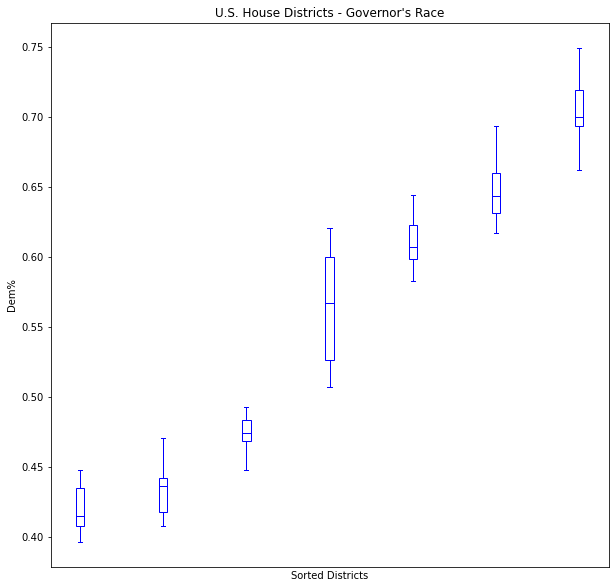

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

draw_plot(np.array(GOVDV[0:]),-1.5,'blue','w')

plt.ylabel("Dem%")
plt.xlabel("Sorted Districts")
ax.set_xticks([])
plt.title("U.S. House Districts - Governor's Race")

plt.show()


And of course you could do these boxplots for the other elections as well!

We can also extract information to plots histograms for seat share.

In [17]:
seats_GOV = []

for j in range(len(GOVDV)):
    numseats=0
    for k in range(7):
        if GOVDV[j][k]>0.5:
            numseats +=1
    seats_GOV.append(numseats)


Plot histogram for Dem seat share:

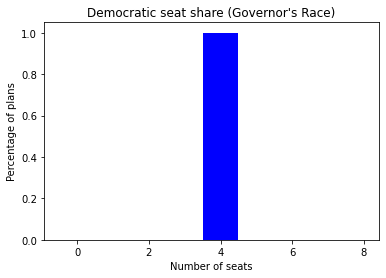

In [18]:
plt.hist(seats_GOV[0:], color = "blue", bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8], density=True)
plt.ylabel("Percentage of plans")
plt.xlabel("Number of seats")
plt.title("Democratic seat share (Governor's Race)")
#plt.legend()
plt.show()

Since we collected data about the number of cut edges in each plan, we can plot a histograms for cut edgesas well.


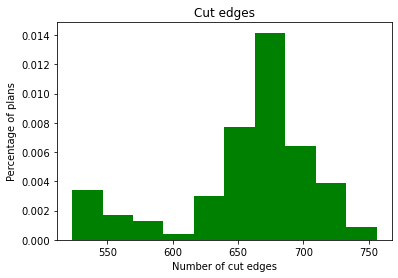

In [19]:
plt.hist(cuts[0:], color = "green", density=True)
plt.ylabel("Percentage of plans")
plt.xlabel("Number of cut edges")
plt.title("Cut edges")
#plt.legend()
plt.show()